# Users Notebook

This notebook serves to test the trained models on participants data of the developed study for a touch sensor application. First we evalute the overall performance of all models on all participants, then the participants are split by temperatures and then the participants which for some reason produced an higher $\Delta V$ than that of the heating resistance.

In [12]:
import numpy as np
import pandas as pd
import torch
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from torchmetrics.classification import MulticlassF1Score

## Load ML models

In [13]:
import torch.nn as nn
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 60)
        self.layer2 = nn.Linear(60, 60)
        self.layer3 = nn.Linear(60, 60)
        self.layer4 = nn.Linear(60, 60)
        
        self.act = nn.ReLU()
        self.output = nn.Linear(60, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))
        x = self.logsoftmax(self.output(x))
        return x

In [14]:
models = {}

for fps in glob('final_trained_models\\*'):
    for model in glob(fps + '\\*'):
        models[model.split('\\')[2][:-4]] = torch.load(model)

## Load Participants Data

In [15]:
subjects_df = pd.read_csv('users_data.csv')

## Normalize data to TPS data & get predictions

In [16]:
# Normalize Data
TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep = ';')

models_list = []
scores = []
subjects = []

for subject in subjects_df['subject'].unique():
    X = subjects_df[subjects_df['subject'] == subject].drop(columns = ['AP', 'subject', 'Predicted AP']).reset_index(drop = True)

    for c in TP_df.drop(columns = ['AP']).columns:
        X[c] = X[c] / TP_df[c].abs().max()

    y = subjects_df[subjects_df['subject'] == subject]['AP']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)  

    for m in models.keys():
        y_pred = models[m](X)

        f1 = MulticlassF1Score(num_classes= 10, ignore_index=0)
        score = f1(y_pred, y) * 100
        scores.append(round(score.item(), 2))
        models_list.append(m)
        subjects.append(subject)


    results_df = pd.DataFrame({'Model': models_list, 'Scores': scores, 'subject': subjects})


# Analyze performance

## Split by temperature Groups

In [17]:
df_temp = results_df.copy()

df_temp['Temperature'] = df_temp['subject'].str.extract('_(\d+)C').astype(int)

# Classify subjects based on temperature
df_temp['Temperature Category'] = df_temp['Temperature'].apply(lambda x: "Below 29ºC" if x < 29 else "29ºC and Above")

# Display the modified dataset
df_temp['Temperature']

0      26
1      26
2      26
3      26
4      26
       ..
340    33
341    33
342    33
343    33
344    33
Name: Temperature, Length: 345, dtype: int32

In [18]:
# Calculate the mean F1 score for each model
model_avg_scores = df_temp.groupby('Model')['Scores'].mean().sort_values(ascending=False)

model_avg_scores

Model
TPSM            59.363043
TPSMk_expLR     59.034348
KTPM            58.160870
TPSM_expLR1     58.077391
TPSM2           58.025217
TPSM_expLR      57.640435
TPSMk_expLR1    57.417826
TPSMk2          57.046087
TPSMk           53.930000
KTPM2           52.753913
KTPM_expLR1     51.709565
TPSMk1          51.190435
KTPM1           50.855652
TPSM1           49.623043
KTPM_expLR      49.260435
Name: Scores, dtype: float64

In [19]:
# Calculate the mean F1 score for each model within each temperature category
temp_category_scores = df_temp.groupby(['Temperature Category', 'Model'])['Scores'].mean().unstack()
temp_category_std = df_temp.groupby(['Temperature Category', 'Model'])['Scores'].std().unstack()
temp_category_scores

Model,KTPM,KTPM1,KTPM2,KTPM_expLR,KTPM_expLR1,TPSM,TPSM1,TPSM2,TPSM_expLR,TPSM_expLR1,TPSMk,TPSMk1,TPSMk2,TPSMk_expLR,TPSMk_expLR1
Temperature Category,,,,,,,,,,,,,,,
29ºC and Above,63.622632,54.873684,59.048421,54.379474,57.286316,65.411053,54.729474,62.623158,62.926842,63.223158,61.105263,56.671579,62.356842,65.026842,63.361579
Below 29ºC,32.217500,31.770000,22.855000,24.945000,25.220000,30.635000,25.367500,36.185000,32.530000,33.635000,19.847500,25.155000,31.820000,30.570000,29.185000


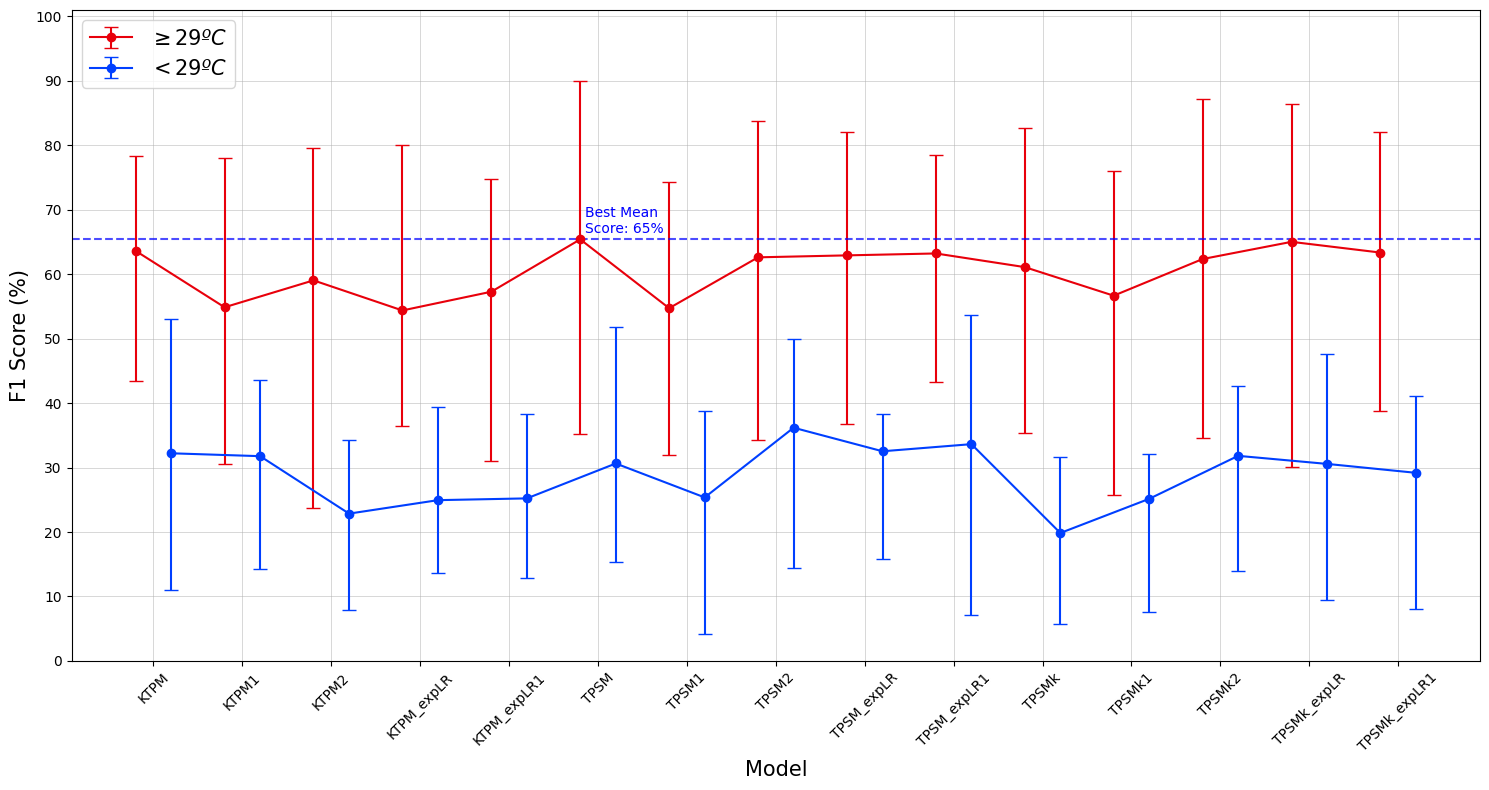

In [20]:
# Calculate the minimum F1 score for each model within each temperature category
temp_category_min = df_temp.groupby(['Temperature Category', 'Model'])['Scores'].min().unstack()
temp_category_max = df_temp.groupby(['Temperature Category', 'Model'])['Scores'].max().unstack()

# Calculate the "errors" as the differences between the mean and the min/max values
lower_error = abs(temp_category_scores - temp_category_min)
upper_error = abs(temp_category_max - temp_category_scores)
plt.style.use("seaborn-v0_8-bright")
#plt.style.use("ggplot")

plt.figure(figsize=(15, 8))
labels = [r"$\geq 29ºC$", r"$<29ºC$"]
colors = ['#E8000B', '#003FFF']
i = 0
# Plot scores with error bars for each temperature category
for temp_category in temp_category_scores.index:
    if i ==0:
        offset = -0.2
    else:
        offset = 0.2
    plt.errorbar([x + offset for x in range(len(temp_category_scores.columns))], 
                 temp_category_scores.loc[temp_category], 
                 yerr=[lower_error.loc[temp_category].values, upper_error.loc[temp_category].values],
                 label=labels[i], marker='o', capsize=5, linestyle='-', color = colors[i])
    i += 1
    
best_mean_score = temp_category_scores.max().max()

# Rest of the plotting details
# plt.title('Model Performance by Temperature')
plt.ylabel('F1 Score (%)', fontsize = 15)
plt.xlabel('Model', fontsize = 15)
plt.ylim(0, 101)
plt.yticks(np.arange(0,110,10))
plt.xticks(ticks=range(len(temp_category_scores.columns)), labels=temp_category_scores.columns, rotation=45)
plt.legend(loc="upper left", fontsize = 15)
plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.7)
plt.axhline(best_mean_score, color='blue', linestyle='--', alpha=0.7)
plt.text(5 -0.15, best_mean_score + 1, f"Best Mean\nScore: {best_mean_score:.0f}%", color='blue', fontsize=10)
plt.tight_layout()
plt.show()


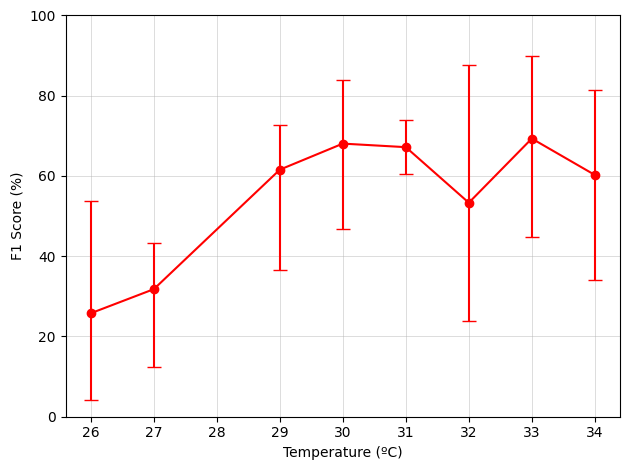

In [21]:
# Calculate the mean, min, and max F1 scores for each temperature
temperature_mean_scores = df_temp.groupby('Temperature')['Scores'].mean()
temperature_min_scores = df_temp.groupby('Temperature')['Scores'].min()
temperature_max_scores = df_temp.groupby('Temperature')['Scores'].max()

# Calculate the "errors" as the differences between the mean and the min/max values
lower_error = temperature_mean_scores - temperature_min_scores
upper_error = temperature_max_scores - temperature_mean_scores

# Plotting the average F1 Score vs. Temperature with error bars

plt.errorbar(temperature_mean_scores.index, 
             temperature_mean_scores, 
             yerr=[lower_error.values, upper_error.values], 
             fmt='o', linestyle = '-', capsize=5, color='r', label='Average F1 Score')

plt.ylabel('F1 Score (%)')
plt.xlabel('Temperature (ºC)')
plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.6)
plt.ylim(0,100)
plt.tight_layout()
plt.show()


## Remove participants with higher $\Delta V$ than that of the heating resistance

In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep=';')

models_list = []
scores = []
subjects = []

for subject in subjects_df['subject'].unique():
    X = subjects_df[subjects_df['subject'] == subject].drop(columns=['AP', 'subject', 'Predicted AP']).reset_index(drop=True)

    # Normalize the X DataFrame
    for c in TP_df.drop(columns=['AP']).columns:
        X[c] = X[c] / TP_df[c].abs().max()

    # Determine the rows where any column has a value greater than 1.5
    if (X.abs() > 1.5).any(axis=1).sum() > 0:  # If any row of this subject's data exceeds 1.5
        print(subject)
        continue  # Skip processing this subject and move to the next one

    y = subjects_df[subjects_df['subject'] == subject]['AP']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    for m in models.keys():
        y_pred = models[m](X)

        f1 = MulticlassF1Score(num_classes=10, ignore_index=0)
        score = f1(y_pred, y) * 100
        scores.append(round(score.item(), 2))
        models_list.append(m)
        subjects.append(subject)

results_df_unorm = pd.DataFrame({'Model': models_list, 'Scores': scores, 'subject': subjects})


S4_34C
S6_32C
S9_32C
S11_32C
S13_32C
S17_27C
S22_32C
S23_33C


In [23]:
df_temp_unorm = results_df_unorm.copy()

# Extract temperature from the 'subject' column
df_temp_unorm['Temperature'] = df_temp_unorm['subject'].str.extract('_(\d+)C').astype(int)

# Classify subjects based on temperature
df_temp_unorm['Temperature Category'] = df_temp_unorm['Temperature'].apply(lambda x: "Below 29ºC" if x < 29 else "29ºC and Above")

In [24]:
# Calculate the mean F1 score for each model within each temperature category
temp_category_scores_unorm = df_temp_unorm.groupby(['Temperature Category', 'Model'])['Scores'].mean().unstack()
temp_category_std_unorm = df_temp_unorm.groupby(['Temperature Category', 'Model'])['Scores'].std().unstack()
temp_category_scores_unorm

Model,KTPM,KTPM1,KTPM2,KTPM_expLR,KTPM_expLR1,TPSM,TPSM1,TPSM2,TPSM_expLR,TPSM_expLR1,TPSMk,TPSMk1,TPSMk2,TPSMk_expLR,TPSMk_expLR1
Temperature Category,,,,,,,,,,,,,,,
29ºC and Above,72.090833,61.495833,67.925000,60.398333,64.254167,77.890833,63.333333,73.352500,73.871667,70.210000,70.762500,66.695833,73.472500,76.5175,72.571667
Below 29ºC,35.336667,33.700000,23.376667,27.346667,28.390000,33.626667,24.860000,34.913333,30.606667,34.456667,22.366667,23.870000,32.423333,30.5400,27.363333


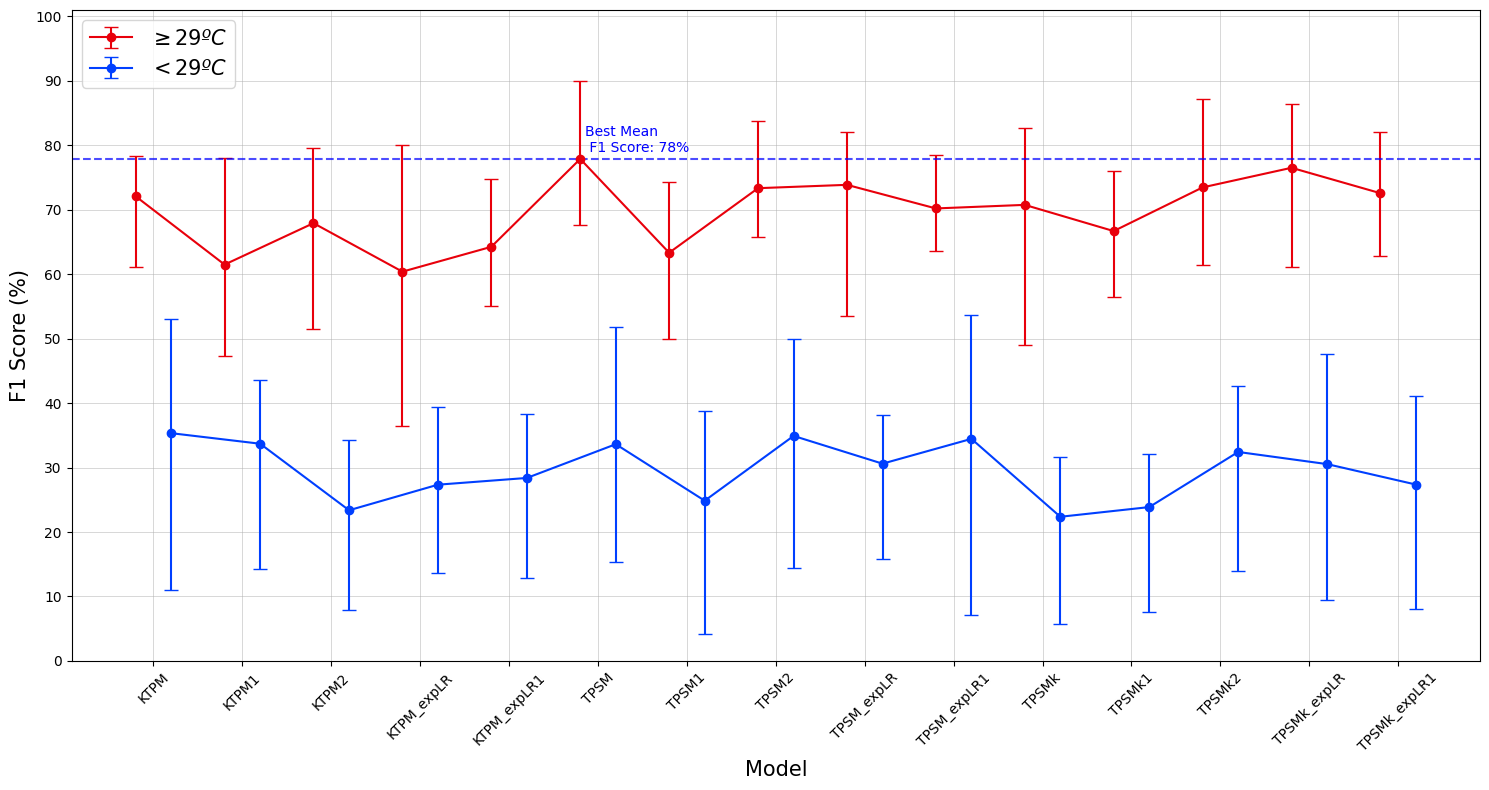

In [25]:
# Calculate the minimum F1 score for each model within each temperature category
temp_category_min = df_temp_unorm.groupby(['Temperature Category', 'Model'])['Scores'].min().unstack()
temp_category_max = df_temp_unorm.groupby(['Temperature Category', 'Model'])['Scores'].max().unstack()

# Calculate the "errors" as the differences between the mean and the min/max values
lower_error = abs(temp_category_scores_unorm - temp_category_min)
upper_error = abs(temp_category_max - temp_category_scores_unorm)
plt.style.use("seaborn-v0_8-bright")
#plt.style.use("ggplot")

plt.figure(figsize=(15, 8))
labels = [r"$\geq 29ºC$", r"$<29ºC$"]
colors = ['#E8000B', '#003FFF']
i = 0
# Plot scores with error bars for each temperature category
for temp_category in temp_category_scores_unorm.index:
    if i ==0:
        offset = -0.2
    else:
        offset = 0.2
    plt.errorbar([x + offset for x in range(len(temp_category_scores_unorm.columns))], 
                 temp_category_scores_unorm.loc[temp_category], 
                 yerr=[lower_error.loc[temp_category].values, upper_error.loc[temp_category].values],
                 label=labels[i], marker='o', capsize=5, linestyle='-', color = colors[i])
    i += 1
    
best_mean_score = temp_category_scores_unorm.max().max()

# Rest of the plotting details
# plt.title('Model Performance by Temperature')
plt.ylabel('F1 Score (%)', fontsize = 15)
plt.xlabel('Model', fontsize = 15)
plt.ylim(0, 101)
plt.yticks(np.arange(0,110,10))
plt.xticks(ticks=range(len(temp_category_scores.columns)), labels=temp_category_scores.columns, rotation=45)
plt.legend(loc="upper left", fontsize = 15)
plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.7)
plt.axhline(best_mean_score, color='b', linestyle='--', alpha=0.7)
plt.text(5 -0.15, best_mean_score + 1, f"Best Mean\n F1 Score: {best_mean_score:.0f}%", color='b', fontsize=10)
plt.tight_layout()
plt.show()